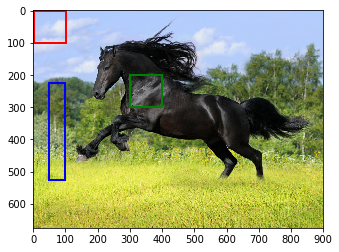

(1, 675, 900, 3) float32


In [137]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc.pilutil import imread

img = imread('horse.jpg')
img = img/np.amax(img)

height,width,ch = img.shape

%matplotlib inline
fig,ax = plt.subplots(1)
ax.imshow(img)
# Create user labels
rect_sky = patches.Rectangle((1,1),100,100,linewidth=2,edgecolor='r',facecolor='none')
rect_grass = patches.Rectangle((50,225),50,300,linewidth=2,edgecolor='b',facecolor='none')
rect_horse = patches.Rectangle((300,200),100,100,linewidth=2,edgecolor='g',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect_sky)
ax.add_patch(rect_grass)
ax.add_patch(rect_horse)
plt.show()

img = np.reshape(img,(1,height,width,ch))
img = img.astype(np.float32)
print(img.shape,img.dtype)

sky_indices = np.zeros((100*100,1),dtype=np.int32)
cnt=-1
for i in np.arange(0,100,1):
    for j in np.arange(0,100,1):
        cnt = cnt + 1
        sky_indices[cnt] = np.ravel_multi_index([i,j], (height,width))

grass_indices = np.zeros((300*50,1),dtype=np.int32)
cnt=-1
for i in np.arange(225,525,1):
    for j in np.arange(50,100,1):
        cnt = cnt + 1
        grass_indices[cnt] = np.ravel_multi_index([i,j], (height,width))

horse_indices = np.zeros((100*100,1),dtype=np.int32)
cnt=-1
for i in np.arange(200,300,1):
    for j in np.arange(300,400,1):
        cnt = cnt + 1
        horse_indices[cnt] = np.ravel_multi_index([i,j], (height,width))

In [115]:
lr = tf.placeholder(tf.float32,shape=None,name="lr")
hp = tf.placeholder(tf.float32,shape=None,name="hp")

X = tf.placeholder(tf.float32,shape=(1,height,width,ch),name="X")

# weight initializer
he_init = tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32)

ksiz = 3 # 3-by-3 kernel throughout
nfilters=16
nclass = 3
# densenet type connections
hidden1 = tf.layers.conv2d(X,filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=tf.nn.elu,kernel_initializer=he_init)
hidden2 = tf.layers.conv2d(tf.concat([X,hidden1],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=tf.nn.elu,kernel_initializer=he_init)
hidden3 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=tf.nn.elu,kernel_initializer=he_init)
hidden4 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=tf.nn.elu,kernel_initializer=he_init)
hidden5 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=tf.nn.elu,kernel_initializer=he_init)
hidden6 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4,hidden5],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=tf.nn.elu,kernel_initializer=he_init)
hidden7 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4,hidden5,hidden6],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=tf.nn.elu,kernel_initializer=he_init)
hidden8 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4,hidden5,hidden6,hidden7],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=tf.nn.elu,kernel_initializer=he_init)
hidden9 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4,hidden5,hidden6,hidden7,hidden8],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=tf.nn.elu,kernel_initializer=he_init)
psi = tf.reshape(tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4,hidden5,hidden6,hidden7,hidden8,hidden9],axis=3),filters=nclass,kernel_size=(ksiz,ksiz),padding="same",activation=tf.exp,kernel_initializer=he_init),[height*width,nclass])
# normalize features to unit vectors
phi = psi / tf.tile(tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(psi),axis=1)),[height*width,1]),[1,nclass])
# loss: within class and between class
loss_00 = tf.reduce_mean(tf.square(tf.matmul(tf.gather_nd(phi,sky_indices),tf.transpose(tf.gather_nd(phi,sky_indices)))-1.0))
loss_11 = tf.reduce_mean(tf.square(tf.matmul(tf.gather_nd(phi,grass_indices),tf.transpose(tf.gather_nd(phi,grass_indices)))-1.0))
loss_22 = tf.reduce_mean(tf.square(tf.matmul(tf.gather_nd(phi,horse_indices),tf.transpose(tf.gather_nd(phi,horse_indices)))-1.0))
loss_01 = tf.reduce_mean(tf.square(tf.matmul(tf.gather_nd(phi,sky_indices),tf.transpose(tf.gather_nd(phi,grass_indices)))))
loss_02 = tf.reduce_mean(tf.square(tf.matmul(tf.gather_nd(phi,sky_indices),tf.transpose(tf.gather_nd(phi,horse_indices)))))
loss_12 = tf.reduce_mean(tf.square(tf.matmul(tf.gather_nd(phi,grass_indices),tf.transpose(tf.gather_nd(phi,horse_indices)))))
# total loss
loss_convnet = loss_00 + loss_11 + loss_22 + loss_01 + loss_02 + loss_12
# optimizer and training op
optimizer = tf.train.AdamOptimizer(lr)
training_op = optimizer.minimize(loss_convnet)

In [117]:
learning_rate = 1e-3
n_epochs = 1000

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        if epoch%100 == 0:
            loss_convnet_val        = loss_convnet.eval(feed_dict={X:img})
            print("Epoch:",epoch,"Convnet loss:",loss_convnet_val)
        sess.run(training_op, feed_dict={X:img,lr:learning_rate})
        if (epoch+1)%10 == 0:
            learning_rate = 0.9 * learning_rate
    loss_convnet_val        = loss_convnet.eval(feed_dict={X:img})
    print("Epoch:",epoch,"Convnet loss:",loss_convnet_val)
    phi_val = phi.eval(feed_dict={X:img})

Epoch: 0 Convnet loss: 2.961
Epoch: 100 Convnet loss: 0.00649551
Epoch: 200 Convnet loss: 0.00180339
Epoch: 300 Convnet loss: 0.00118888
Epoch: 400 Convnet loss: 0.00102541
Epoch: 500 Convnet loss: 0.000969573
Epoch: 600 Convnet loss: 0.000948853
Epoch: 700 Convnet loss: 0.000940988
Epoch: 800 Convnet loss: 0.000938043
Epoch: 900 Convnet loss: 0.000936992
Epoch: 999 Convnet loss: 0.000936665


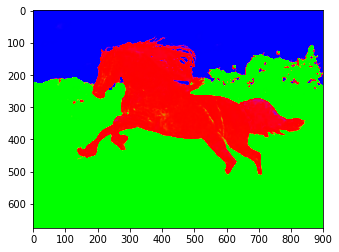

In [118]:
ClassIndicator = phi_val.reshape((height,width,nclass))
%matplotlib inline
plt.imshow(ClassIndicator)


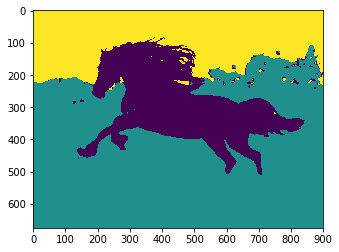

In [119]:
Seg = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        val   = -1
        label =-1
        for n in range(nclass):
            if ClassIndicator[i,j,n]>val:
                val = ClassIndicator[i,j,n]
                label = n
        Seg[i,j] = label

%matplotlib inline
plt.imshow(Seg)
